In [1]:
from __future__ import division, print_function
from keras import backend as K
from keras.applications import resnet50
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, merge
from keras.layers.core import Activation, Dense, Dropout, Lambda
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from random import shuffle
from scipy.misc import imresize
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [3]:
DATA_DIR = "/"
IMAGE_DIR = os.path.join(DATA_DIR, "images_after_crop")
TEST_B_DIR = os.path.join(DATA_DIR, "pigtest_b")

BATCH_SIZE = 64
NUM_EPOCHS = 12

In [4]:
VECTOR_SIZE = 2048
VECTOR_FILE = os.path.join("/vector_data/", "resnet-vectors-cropped-images.tsv")
VECTOR_FILE_TEST_B = os.path.join("/vector_data/", "resnet-vectors-test-b.tsv")

## Prepare Data

We use the naming convention to identify as a positive pair any two images that are part of the same group, and negative as a random pair of images in different groups.

In [5]:
def get_random_image(img_groups, group_names, gid):
    gname = group_names[gid]
    photos = img_groups[gname]
    pid = np.random.choice(np.arange(len(photos)), size=1)[0]
    pname = photos[pid]
    return gname + pname + ".jpg"
    
def create_triples(image_dir):
    img_groups = {}
    image_files = [x for x in os.listdir(image_dir) if not (x.startswith('.'))]
    for img_file in image_files:
        prefix, suffix = img_file.split(".")
        gid, pid = prefix[0:2], prefix[2:]
        if img_groups.has_key(gid):
            img_groups[gid].append(pid)
        else:
            img_groups[gid] = [pid]
    pos_triples, neg_triples = [], []
    # positive pairs are any combination of images in same group
    for key in img_groups.keys():
        triples = [(key + x[0] + ".jpg", key + x[1] + ".jpg", 1) 
                 for x in itertools.combinations(img_groups[key], 2)]
        pos_triples.extend(triples)
    # need equal number of negative examples
    group_names = list(img_groups.keys())
    for i in range(len(pos_triples)):
        g1, g2 = np.random.choice(np.arange(len(group_names)), size=2, replace=False)
        left = get_random_image(img_groups, group_names, g1)
        right = get_random_image(img_groups, group_names, g2)
        neg_triples.append((left, right, 0))
    pos_triples.extend(neg_triples)
    shuffle(pos_triples)
    return pos_triples

triples_data = create_triples(IMAGE_DIR)

print(len(triples_data))
print(triples_data[0:100])

120752
[('30frame57_c.jpg', '30frame17_c.jpg', 1), ('04frame39_c.jpg', '28frame44_c.jpg', 0), ('14frame7_c.jpg', '14frame47_c.jpg', 1), ('30frame18_c.jpg', '24frame1_c.jpg', 0), ('20frame4_c.jpg', '20frame53_c.jpg', 1), ('10frame8_c.jpg', '10frame63_c.jpg', 1), ('25frame61_c.jpg', '25frame28_c.jpg', 1), ('24frame6_c.jpg', '15frame31_c.jpg', 0), ('17frame28_c.jpg', '17frame26_c.jpg', 1), ('05frame32_c.jpg', '05frame12_c.jpg', 1), ('24frame54_c.jpg', '24frame12_c.jpg', 1), ('18frame60_c.jpg', '18frame61_c.jpg', 1), ('15frame56_c.jpg', '15frame53_c.jpg', 1), ('19frame13_c.jpg', '30frame50_c.jpg', 0), ('08frame58_c.jpg', '01frame6_c.jpg', 0), ('05frame64_c.jpg', '20frame42_c.jpg', 0), ('22frame10_c.jpg', '01frame23_c.jpg', 0), ('19frame13_c.jpg', '19frame18_c.jpg', 1), ('24frame43_c.jpg', '24frame57_c.jpg', 1), ('17frame58_c.jpg', '17frame30_c.jpg', 1), ('23frame26_c.jpg', '01frame18_c.jpg', 0), ('04frame57_c.jpg', '04frame61_c.jpg', 1), ('05frame18_c.jpg', '22frame35_c.jpg', 0), ('23frame

Using the triples, we create a cache keyed by image filename and whose value is the numpy vector represented by the image. Since we plan on using pretrained resnet50 network, our images are resized to (224, 224, 3).

In [6]:
def load_image_cache(image_cache, image_filename):
    image = plt.imread(os.path.join(IMAGE_DIR, image_filename))
    image = imresize(image, (224, 224))
    image = image.astype("float32")
    image = resnet50.preprocess_input(image)
    image_cache[image_filename] = image
    
image_cache = {}
num_pairs = len(triples_data)
for i, (image_filename_l, image_filename_r, _) in enumerate(triples_data):
    if i % 1000 == 0:
        print("images from {:d}/{:d} pairs loaded to cache".format(i, num_pairs))
    if not image_cache.has_key(image_filename_l):
        load_image_cache(image_cache, image_filename_l)
    if not image_cache.has_key(image_filename_r):
        load_image_cache(image_cache, image_filename_r)
print("images from {:d}/{:d} pairs loaded to cache, COMPLETE".format(i, num_pairs))

images from 0/120752 pairs loaded to cache
images from 1000/120752 pairs loaded to cache
images from 2000/120752 pairs loaded to cache
images from 3000/120752 pairs loaded to cache
images from 4000/120752 pairs loaded to cache
images from 5000/120752 pairs loaded to cache
images from 6000/120752 pairs loaded to cache
images from 7000/120752 pairs loaded to cache
images from 8000/120752 pairs loaded to cache
images from 9000/120752 pairs loaded to cache
images from 10000/120752 pairs loaded to cache
images from 11000/120752 pairs loaded to cache
images from 12000/120752 pairs loaded to cache
images from 13000/120752 pairs loaded to cache
images from 14000/120752 pairs loaded to cache
images from 15000/120752 pairs loaded to cache
images from 16000/120752 pairs loaded to cache
images from 17000/120752 pairs loaded to cache
images from 18000/120752 pairs loaded to cache
images from 19000/120752 pairs loaded to cache
images from 20000/120752 pairs loaded to cache
images from 21000/120752 p

In [7]:
def pair_generator(triples, image_cache, datagens, batch_size=32):
    while True:
        # shuffle once per batch
        indices = np.random.permutation(np.arange(len(triples)))
        num_batches = len(triples) // batch_size
        for bid in range(num_batches):
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [triples[i] for i in batch_indices]
            X1 = np.zeros((batch_size, 224, 224, 3))
            X2 = np.zeros((batch_size, 224, 224, 3))
            Y = np.zeros((batch_size, 2))
            for i, (image_filename_l, image_filename_r, label) in enumerate(batch):
                if datagens is None or len(datagens) == 0:
                    X1[i] = image_cache[image_filename_l]
                    X2[i] = image_cache[image_filename_r]
                else:
                    X1[i] = datagens[0].random_transform(image_cache[image_filename_l])
                    X2[i] = datagens[1].random_transform(image_cache[image_filename_r])
                Y[i] = [1, 0] if label == 0 else [0, 1]
            yield [X1, X2], Y


datagen_args = dict(rotation_range=10,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.2)
datagens = [ImageDataGenerator(**datagen_args),
            ImageDataGenerator(**datagen_args)]
pair_gen = pair_generator(triples_data, image_cache, datagens, 32)
[X1, X2], Y = pair_gen.next()
print(X1.shape, X2.shape, Y.shape)

(32, 224, 224, 3) (32, 224, 224, 3) (32, 2)


## Define Model

The model is composed of two pretrained Resnet50 networks without their last prediction layer, connected to a merge layer that computes element-wise dot product of the two (2048,) sized vectors produced by the Resnet50. This is then fed into a 3 layer fully connected network that produces the similar / not similar prediction.

The Resnet50 network weights are frozen, and the Fully Connected network weights are loaded from one trained using pre-computed image vectors and allowed to be fine-tuned.

In [8]:
# distance measure
def cosine_distance(vecs, normalize=False):
    x, y = vecs
    if normalize:
        x = K.l2_normalize(x, axis=0)
        y = K.l2_normalize(x, axis=0)
    return K.prod(K.stack([x, y], axis=1), axis=1)

def cosine_distance_output_shape(shapes):
    return shapes[0]

vecs = [np.random.random((10,)), np.random.random((10,))]
print(vecs[0].shape, vecs[1].shape)
s = cosine_distance(vecs)
print(s.shape)

(10,) (10,)
(10,)


In [19]:
# load 2 copies of the resnet50 model
# in case of a siamese network, the same instance of the network will be trained,
# but in our case the network is untrainable, so we can have 2 copies
resnet50_1 = resnet50.ResNet50(weights="imagenet", include_top=True)
resnet50_2 = resnet50.ResNet50(weights="imagenet", include_top=True)

102072320/102853048 [============================>.] - ETA: 0s

In [27]:
# Here the last two layers are avg_pool and prediction as shown below:
#    avg_pool (None, 8, 8, 2048) (None, 2048)
#    predictions (None, 2048) (None, 1000)
#
for layer in resnet50_2.layers:
     print(layer.name, layer.input_shape, layer.output_shape)

input_2_2_2 (None, 224, 224, 3) (None, 224, 224, 3)
conv1_2_2 (None, 224, 224, 3) (None, 112, 112, 64)
bn_conv1_2_2 (None, 112, 112, 64) (None, 112, 112, 64)
activation_50_2_2 (None, 112, 112, 64) (None, 112, 112, 64)
max_pooling2d_2_2_2 (None, 112, 112, 64) (None, 55, 55, 64)
res2a_branch2a_2_2 (None, 55, 55, 64) (None, 55, 55, 64)
bn2a_branch2a_2_2 (None, 55, 55, 64) (None, 55, 55, 64)
activation_51_2_2 (None, 55, 55, 64) (None, 55, 55, 64)
res2a_branch2b_2_2 (None, 55, 55, 64) (None, 55, 55, 64)
bn2a_branch2b_2_2 (None, 55, 55, 64) (None, 55, 55, 64)
activation_52_2_2 (None, 55, 55, 64) (None, 55, 55, 64)
res2a_branch2c_2_2 (None, 55, 55, 64) (None, 55, 55, 256)
res2a_branch1_2_2 (None, 55, 55, 64) (None, 55, 55, 256)
bn2a_branch2c_2_2 (None, 55, 55, 256) (None, 55, 55, 256)
bn2a_branch1_2_2 (None, 55, 55, 256) (None, 55, 55, 256)
add_17_2_2 [(None, 55, 55, 256), (None, 55, 55, 256)] (None, 55, 55, 256)
activation_53_2_2 (None, 55, 55, 256) (None, 55, 55, 256)
res2b_branch2a_2_2 (No

In [25]:
# freeze weights on the resnet50 network and give each layer a unique name
# since we will combine them into a single network
for layer in resnet50_1.layers:
    layer.trainable = False
    layer.name = layer.name + "_1"
for layer in resnet50_2.layers:
    layer.trainable = False
    layer.name = layer.name + "_2"

In [28]:
# outputs of the resnet50 networks, these will be connected to our head FCN
vector_1 = resnet50_1.get_layer("flatten_1_1_1").output
vector_2 = resnet50_2.get_layer("flatten_2_2_2").output

In [31]:
print(vector_1)

Tensor("flatten_1/Reshape:0", shape=(?, ?), dtype=float32)


In [32]:
# load the pretrained similarity head network. This has been trained to predict similar
# images using image vectors
sim_head = load_model(os.path.join("/models_trained", "resnet50_cropped-dot-final.h5"))
for layer in sim_head.layers:
    print(layer.name, layer.input_shape, layer.output_shape)

input_3 (None, 2048) (None, 2048)
input_4 (None, 2048) (None, 2048)
lambda_2 [(None, 2048), (None, 2048)] (None, 2048)
dense_4 (None, 2048) (None, 512)
dropout_3 (None, 512) (None, 512)
activation_4 (None, 512) (None, 512)
dense_5 (None, 512) (None, 128)
dropout_4 (None, 128) (None, 128)
activation_5 (None, 128) (None, 128)
dense_6 (None, 128) (None, 2)
activation_6 (None, 2) (None, 2)


In [33]:
# attach output of the resnet50 networks to the similarity head
# output is a prediction tensor
prediction = sim_head([vector_1, vector_2])

In [34]:
# declare a model that takes image inputs on its truncated resnet50 subnetworks
# and returns the prediction as the output. Inputs are Input(shape=(224, 224, 3))
model = Model(inputs=[resnet50_1.input, resnet50_2.input], outputs=prediction)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## Train Network

In [35]:
BEST_MODEL_FILE = os.path.join("/models_trained", "resnet50_cropped-full-net-dot-best.h5")
FINAL_MODEL_FILE = os.path.join("/models_trained", "resnet50_cropped-full-net-dot-final.h5")

In [11]:
triples_data_trainval, triples_data_test = train_test_split(triples_data, train_size=0.98)
triples_data_train, triples_data_val = train_test_split(triples_data_trainval, train_size=0.9)
print(len(triples_data_train), len(triples_data_val), len(triples_data_test))

106502 11834 2416


/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [39]:
datagen_args = dict(rotation_range=10,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.2)
datagens = [ImageDataGenerator(**datagen_args),
            ImageDataGenerator(**datagen_args)]
train_pair_gen = pair_generator(triples_data_train, image_cache, datagens, BATCH_SIZE)
val_pair_gen = pair_generator(triples_data_val, image_cache, None, BATCH_SIZE)

In [40]:
num_train_steps = len(triples_data_train) // BATCH_SIZE
num_val_steps = len(triples_data_val) // BATCH_SIZE

In [41]:
checkpoint = ModelCheckpoint(filepath=BEST_MODEL_FILE, save_best_only=True)
history = model.fit_generator(train_pair_gen, 
                             steps_per_epoch=num_train_steps,
                             epochs=NUM_EPOCHS,
                             validation_data=val_pair_gen,
                             validation_steps=num_val_steps,
                             callbacks=[checkpoint])

Epoch 1/20
   8/3328 [..............................] - ETA: 74137s - loss: 2.1483 - acc: 0.6211

KeyboardInterrupt: 

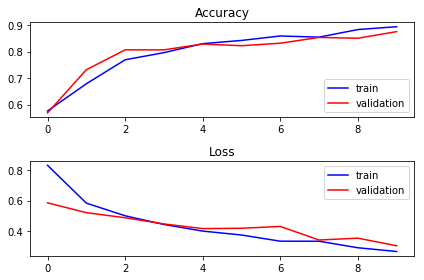

In [19]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="blue", label="train")
plt.plot(history.history["val_acc"], color="red", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="blue", label="train")
plt.plot(history.history["val_loss"], color="red", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [13]:
def get_test_b_triples(image_dir, test_b_dir):
    test_b_triples = []
    image_names_rev = [x for x in os.listdir(image_dir) if not (x.startswith('.'))]
    test_b_names = [x for x in os.listdir(test_b_dir) if not (x.startswith('.'))]
    for test_b_name in test_b_names:
        for image_name in image_names_rev:
            test_b_triples.append((test_b_name, image_name, 0))
    return test_b_triples

In [15]:
test_triples_data = get_test_b_triples(IMAGE_DIR,TEST_B_DIR)

def load_image_cache(image_cache, image_filename, IM_DIR):
    image = plt.imread(os.path.join(IM_DIR, image_filename))
    image = imresize(image, (224, 224))
    image = image.astype("float32")
    image = resnet50.preprocess_input(image)
    image_cache[image_filename] = image
    
image_cache = {}
num_pairs = len(test_triples_data)
for i, (image_filename_l, image_filename_r, _) in enumerate(test_triples_data):
    if i % 1000 == 0:
        print("images from {:d}/{:d} pairs loaded to cache".format(i, num_pairs))
    if not image_cache.has_key(image_filename_l):
        load_image_cache(image_cache, image_filename_l, TEST_B_DIR)
    if not image_cache.has_key(image_filename_r):
        load_image_cache(image_cache, image_filename_r, IMAGE_DIR)
print("images from {:d}/{:d} pairs loaded to cache, COMPLETE".format(i, num_pairs))

images from 0/5751000 pairs loaded to cache
images from 1000/5751000 pairs loaded to cache
images from 2000/5751000 pairs loaded to cache
images from 3000/5751000 pairs loaded to cache
images from 4000/5751000 pairs loaded to cache
images from 5000/5751000 pairs loaded to cache
images from 6000/5751000 pairs loaded to cache
images from 7000/5751000 pairs loaded to cache
images from 8000/5751000 pairs loaded to cache
images from 9000/5751000 pairs loaded to cache
images from 10000/5751000 pairs loaded to cache
images from 11000/5751000 pairs loaded to cache
images from 12000/5751000 pairs loaded to cache
images from 13000/5751000 pairs loaded to cache
images from 14000/5751000 pairs loaded to cache
images from 15000/5751000 pairs loaded to cache
images from 16000/5751000 pairs loaded to cache
images from 17000/5751000 pairs loaded to cache
images from 18000/5751000 pairs loaded to cache
images from 19000/5751000 pairs loaded to cache
images from 20000/5751000 pairs loaded to cache
image

images from 175000/5751000 pairs loaded to cache
images from 176000/5751000 pairs loaded to cache
images from 177000/5751000 pairs loaded to cache
images from 178000/5751000 pairs loaded to cache
images from 179000/5751000 pairs loaded to cache
images from 180000/5751000 pairs loaded to cache
images from 181000/5751000 pairs loaded to cache
images from 182000/5751000 pairs loaded to cache
images from 183000/5751000 pairs loaded to cache
images from 184000/5751000 pairs loaded to cache
images from 185000/5751000 pairs loaded to cache
images from 186000/5751000 pairs loaded to cache
images from 187000/5751000 pairs loaded to cache
images from 188000/5751000 pairs loaded to cache
images from 189000/5751000 pairs loaded to cache
images from 190000/5751000 pairs loaded to cache
images from 191000/5751000 pairs loaded to cache
images from 192000/5751000 pairs loaded to cache
images from 193000/5751000 pairs loaded to cache
images from 194000/5751000 pairs loaded to cache
images from 195000/5

images from 346000/5751000 pairs loaded to cache
images from 347000/5751000 pairs loaded to cache
images from 348000/5751000 pairs loaded to cache
images from 349000/5751000 pairs loaded to cache
images from 350000/5751000 pairs loaded to cache
images from 351000/5751000 pairs loaded to cache
images from 352000/5751000 pairs loaded to cache
images from 353000/5751000 pairs loaded to cache
images from 354000/5751000 pairs loaded to cache
images from 355000/5751000 pairs loaded to cache
images from 356000/5751000 pairs loaded to cache
images from 357000/5751000 pairs loaded to cache
images from 358000/5751000 pairs loaded to cache
images from 359000/5751000 pairs loaded to cache
images from 360000/5751000 pairs loaded to cache
images from 361000/5751000 pairs loaded to cache
images from 362000/5751000 pairs loaded to cache
images from 363000/5751000 pairs loaded to cache
images from 364000/5751000 pairs loaded to cache
images from 365000/5751000 pairs loaded to cache
images from 366000/5

images from 528000/5751000 pairs loaded to cache
images from 529000/5751000 pairs loaded to cache
images from 530000/5751000 pairs loaded to cache
images from 531000/5751000 pairs loaded to cache
images from 532000/5751000 pairs loaded to cache
images from 533000/5751000 pairs loaded to cache
images from 534000/5751000 pairs loaded to cache
images from 535000/5751000 pairs loaded to cache
images from 536000/5751000 pairs loaded to cache
images from 537000/5751000 pairs loaded to cache
images from 538000/5751000 pairs loaded to cache
images from 539000/5751000 pairs loaded to cache
images from 540000/5751000 pairs loaded to cache
images from 541000/5751000 pairs loaded to cache
images from 542000/5751000 pairs loaded to cache
images from 543000/5751000 pairs loaded to cache
images from 544000/5751000 pairs loaded to cache
images from 545000/5751000 pairs loaded to cache
images from 546000/5751000 pairs loaded to cache
images from 547000/5751000 pairs loaded to cache
images from 548000/5

images from 696000/5751000 pairs loaded to cache
images from 697000/5751000 pairs loaded to cache
images from 698000/5751000 pairs loaded to cache
images from 699000/5751000 pairs loaded to cache
images from 700000/5751000 pairs loaded to cache
images from 701000/5751000 pairs loaded to cache
images from 702000/5751000 pairs loaded to cache
images from 703000/5751000 pairs loaded to cache
images from 704000/5751000 pairs loaded to cache
images from 705000/5751000 pairs loaded to cache
images from 706000/5751000 pairs loaded to cache
images from 707000/5751000 pairs loaded to cache
images from 708000/5751000 pairs loaded to cache
images from 709000/5751000 pairs loaded to cache
images from 710000/5751000 pairs loaded to cache
images from 711000/5751000 pairs loaded to cache
images from 712000/5751000 pairs loaded to cache
images from 713000/5751000 pairs loaded to cache
images from 714000/5751000 pairs loaded to cache
images from 715000/5751000 pairs loaded to cache
images from 716000/5

images from 874000/5751000 pairs loaded to cache
images from 875000/5751000 pairs loaded to cache
images from 876000/5751000 pairs loaded to cache
images from 877000/5751000 pairs loaded to cache
images from 878000/5751000 pairs loaded to cache
images from 879000/5751000 pairs loaded to cache
images from 880000/5751000 pairs loaded to cache
images from 881000/5751000 pairs loaded to cache
images from 882000/5751000 pairs loaded to cache
images from 883000/5751000 pairs loaded to cache
images from 884000/5751000 pairs loaded to cache
images from 885000/5751000 pairs loaded to cache
images from 886000/5751000 pairs loaded to cache
images from 887000/5751000 pairs loaded to cache
images from 888000/5751000 pairs loaded to cache
images from 889000/5751000 pairs loaded to cache
images from 890000/5751000 pairs loaded to cache
images from 891000/5751000 pairs loaded to cache
images from 892000/5751000 pairs loaded to cache
images from 893000/5751000 pairs loaded to cache
images from 894000/5

images from 1041000/5751000 pairs loaded to cache
images from 1042000/5751000 pairs loaded to cache
images from 1043000/5751000 pairs loaded to cache
images from 1044000/5751000 pairs loaded to cache
images from 1045000/5751000 pairs loaded to cache
images from 1046000/5751000 pairs loaded to cache
images from 1047000/5751000 pairs loaded to cache
images from 1048000/5751000 pairs loaded to cache
images from 1049000/5751000 pairs loaded to cache
images from 1050000/5751000 pairs loaded to cache
images from 1051000/5751000 pairs loaded to cache
images from 1052000/5751000 pairs loaded to cache
images from 1053000/5751000 pairs loaded to cache
images from 1054000/5751000 pairs loaded to cache
images from 1055000/5751000 pairs loaded to cache
images from 1056000/5751000 pairs loaded to cache
images from 1057000/5751000 pairs loaded to cache
images from 1058000/5751000 pairs loaded to cache
images from 1059000/5751000 pairs loaded to cache
images from 1060000/5751000 pairs loaded to cache


images from 1216000/5751000 pairs loaded to cache
images from 1217000/5751000 pairs loaded to cache
images from 1218000/5751000 pairs loaded to cache
images from 1219000/5751000 pairs loaded to cache
images from 1220000/5751000 pairs loaded to cache
images from 1221000/5751000 pairs loaded to cache
images from 1222000/5751000 pairs loaded to cache
images from 1223000/5751000 pairs loaded to cache
images from 1224000/5751000 pairs loaded to cache
images from 1225000/5751000 pairs loaded to cache
images from 1226000/5751000 pairs loaded to cache
images from 1227000/5751000 pairs loaded to cache
images from 1228000/5751000 pairs loaded to cache
images from 1229000/5751000 pairs loaded to cache
images from 1230000/5751000 pairs loaded to cache
images from 1231000/5751000 pairs loaded to cache
images from 1232000/5751000 pairs loaded to cache
images from 1233000/5751000 pairs loaded to cache
images from 1234000/5751000 pairs loaded to cache
images from 1235000/5751000 pairs loaded to cache


images from 1388000/5751000 pairs loaded to cache
images from 1389000/5751000 pairs loaded to cache
images from 1390000/5751000 pairs loaded to cache
images from 1391000/5751000 pairs loaded to cache
images from 1392000/5751000 pairs loaded to cache
images from 1393000/5751000 pairs loaded to cache
images from 1394000/5751000 pairs loaded to cache
images from 1395000/5751000 pairs loaded to cache
images from 1396000/5751000 pairs loaded to cache
images from 1397000/5751000 pairs loaded to cache
images from 1398000/5751000 pairs loaded to cache
images from 1399000/5751000 pairs loaded to cache
images from 1400000/5751000 pairs loaded to cache
images from 1401000/5751000 pairs loaded to cache
images from 1402000/5751000 pairs loaded to cache
images from 1403000/5751000 pairs loaded to cache
images from 1404000/5751000 pairs loaded to cache
images from 1405000/5751000 pairs loaded to cache
images from 1406000/5751000 pairs loaded to cache
images from 1407000/5751000 pairs loaded to cache


images from 1557000/5751000 pairs loaded to cache
images from 1558000/5751000 pairs loaded to cache
images from 1559000/5751000 pairs loaded to cache
images from 1560000/5751000 pairs loaded to cache
images from 1561000/5751000 pairs loaded to cache
images from 1562000/5751000 pairs loaded to cache
images from 1563000/5751000 pairs loaded to cache
images from 1564000/5751000 pairs loaded to cache
images from 1565000/5751000 pairs loaded to cache
images from 1566000/5751000 pairs loaded to cache
images from 1567000/5751000 pairs loaded to cache
images from 1568000/5751000 pairs loaded to cache
images from 1569000/5751000 pairs loaded to cache
images from 1570000/5751000 pairs loaded to cache
images from 1571000/5751000 pairs loaded to cache
images from 1572000/5751000 pairs loaded to cache
images from 1573000/5751000 pairs loaded to cache
images from 1574000/5751000 pairs loaded to cache
images from 1575000/5751000 pairs loaded to cache
images from 1576000/5751000 pairs loaded to cache


images from 1722000/5751000 pairs loaded to cache
images from 1723000/5751000 pairs loaded to cache
images from 1724000/5751000 pairs loaded to cache
images from 1725000/5751000 pairs loaded to cache
images from 1726000/5751000 pairs loaded to cache
images from 1727000/5751000 pairs loaded to cache
images from 1728000/5751000 pairs loaded to cache
images from 1729000/5751000 pairs loaded to cache
images from 1730000/5751000 pairs loaded to cache
images from 1731000/5751000 pairs loaded to cache
images from 1732000/5751000 pairs loaded to cache
images from 1733000/5751000 pairs loaded to cache
images from 1734000/5751000 pairs loaded to cache
images from 1735000/5751000 pairs loaded to cache
images from 1736000/5751000 pairs loaded to cache
images from 1737000/5751000 pairs loaded to cache
images from 1738000/5751000 pairs loaded to cache
images from 1739000/5751000 pairs loaded to cache
images from 1740000/5751000 pairs loaded to cache
images from 1741000/5751000 pairs loaded to cache


images from 1891000/5751000 pairs loaded to cache
images from 1892000/5751000 pairs loaded to cache
images from 1893000/5751000 pairs loaded to cache
images from 1894000/5751000 pairs loaded to cache
images from 1895000/5751000 pairs loaded to cache
images from 1896000/5751000 pairs loaded to cache
images from 1897000/5751000 pairs loaded to cache
images from 1898000/5751000 pairs loaded to cache
images from 1899000/5751000 pairs loaded to cache
images from 1900000/5751000 pairs loaded to cache
images from 1901000/5751000 pairs loaded to cache
images from 1902000/5751000 pairs loaded to cache
images from 1903000/5751000 pairs loaded to cache
images from 1904000/5751000 pairs loaded to cache
images from 1905000/5751000 pairs loaded to cache
images from 1906000/5751000 pairs loaded to cache
images from 1907000/5751000 pairs loaded to cache
images from 1908000/5751000 pairs loaded to cache
images from 1909000/5751000 pairs loaded to cache
images from 1910000/5751000 pairs loaded to cache


images from 2059000/5751000 pairs loaded to cache
images from 2060000/5751000 pairs loaded to cache
images from 2061000/5751000 pairs loaded to cache
images from 2062000/5751000 pairs loaded to cache
images from 2063000/5751000 pairs loaded to cache
images from 2064000/5751000 pairs loaded to cache
images from 2065000/5751000 pairs loaded to cache
images from 2066000/5751000 pairs loaded to cache
images from 2067000/5751000 pairs loaded to cache
images from 2068000/5751000 pairs loaded to cache
images from 2069000/5751000 pairs loaded to cache
images from 2070000/5751000 pairs loaded to cache
images from 2071000/5751000 pairs loaded to cache
images from 2072000/5751000 pairs loaded to cache
images from 2073000/5751000 pairs loaded to cache
images from 2074000/5751000 pairs loaded to cache
images from 2075000/5751000 pairs loaded to cache
images from 2076000/5751000 pairs loaded to cache
images from 2077000/5751000 pairs loaded to cache
images from 2078000/5751000 pairs loaded to cache


images from 2240000/5751000 pairs loaded to cache
images from 2241000/5751000 pairs loaded to cache
images from 2242000/5751000 pairs loaded to cache
images from 2243000/5751000 pairs loaded to cache
images from 2244000/5751000 pairs loaded to cache
images from 2245000/5751000 pairs loaded to cache
images from 2246000/5751000 pairs loaded to cache
images from 2247000/5751000 pairs loaded to cache
images from 2248000/5751000 pairs loaded to cache
images from 2249000/5751000 pairs loaded to cache
images from 2250000/5751000 pairs loaded to cache
images from 2251000/5751000 pairs loaded to cache
images from 2252000/5751000 pairs loaded to cache
images from 2253000/5751000 pairs loaded to cache
images from 2254000/5751000 pairs loaded to cache
images from 2255000/5751000 pairs loaded to cache
images from 2256000/5751000 pairs loaded to cache
images from 2257000/5751000 pairs loaded to cache
images from 2258000/5751000 pairs loaded to cache
images from 2259000/5751000 pairs loaded to cache


images from 2406000/5751000 pairs loaded to cache
images from 2407000/5751000 pairs loaded to cache
images from 2408000/5751000 pairs loaded to cache
images from 2409000/5751000 pairs loaded to cache
images from 2410000/5751000 pairs loaded to cache
images from 2411000/5751000 pairs loaded to cache
images from 2412000/5751000 pairs loaded to cache
images from 2413000/5751000 pairs loaded to cache
images from 2414000/5751000 pairs loaded to cache
images from 2415000/5751000 pairs loaded to cache
images from 2416000/5751000 pairs loaded to cache
images from 2417000/5751000 pairs loaded to cache
images from 2418000/5751000 pairs loaded to cache
images from 2419000/5751000 pairs loaded to cache
images from 2420000/5751000 pairs loaded to cache
images from 2421000/5751000 pairs loaded to cache
images from 2422000/5751000 pairs loaded to cache
images from 2423000/5751000 pairs loaded to cache
images from 2424000/5751000 pairs loaded to cache
images from 2425000/5751000 pairs loaded to cache


images from 2573000/5751000 pairs loaded to cache
images from 2574000/5751000 pairs loaded to cache
images from 2575000/5751000 pairs loaded to cache
images from 2576000/5751000 pairs loaded to cache
images from 2577000/5751000 pairs loaded to cache
images from 2578000/5751000 pairs loaded to cache
images from 2579000/5751000 pairs loaded to cache
images from 2580000/5751000 pairs loaded to cache
images from 2581000/5751000 pairs loaded to cache
images from 2582000/5751000 pairs loaded to cache
images from 2583000/5751000 pairs loaded to cache
images from 2584000/5751000 pairs loaded to cache
images from 2585000/5751000 pairs loaded to cache
images from 2586000/5751000 pairs loaded to cache
images from 2587000/5751000 pairs loaded to cache
images from 2588000/5751000 pairs loaded to cache
images from 2589000/5751000 pairs loaded to cache
images from 2590000/5751000 pairs loaded to cache
images from 2591000/5751000 pairs loaded to cache
images from 2592000/5751000 pairs loaded to cache


images from 2751000/5751000 pairs loaded to cache
images from 2752000/5751000 pairs loaded to cache
images from 2753000/5751000 pairs loaded to cache
images from 2754000/5751000 pairs loaded to cache
images from 2755000/5751000 pairs loaded to cache
images from 2756000/5751000 pairs loaded to cache
images from 2757000/5751000 pairs loaded to cache
images from 2758000/5751000 pairs loaded to cache
images from 2759000/5751000 pairs loaded to cache
images from 2760000/5751000 pairs loaded to cache
images from 2761000/5751000 pairs loaded to cache
images from 2762000/5751000 pairs loaded to cache
images from 2763000/5751000 pairs loaded to cache
images from 2764000/5751000 pairs loaded to cache
images from 2765000/5751000 pairs loaded to cache
images from 2766000/5751000 pairs loaded to cache
images from 2767000/5751000 pairs loaded to cache
images from 2768000/5751000 pairs loaded to cache
images from 2769000/5751000 pairs loaded to cache
images from 2770000/5751000 pairs loaded to cache


images from 2926000/5751000 pairs loaded to cache
images from 2927000/5751000 pairs loaded to cache
images from 2928000/5751000 pairs loaded to cache
images from 2929000/5751000 pairs loaded to cache
images from 2930000/5751000 pairs loaded to cache
images from 2931000/5751000 pairs loaded to cache
images from 2932000/5751000 pairs loaded to cache
images from 2933000/5751000 pairs loaded to cache
images from 2934000/5751000 pairs loaded to cache
images from 2935000/5751000 pairs loaded to cache
images from 2936000/5751000 pairs loaded to cache
images from 2937000/5751000 pairs loaded to cache
images from 2938000/5751000 pairs loaded to cache
images from 2939000/5751000 pairs loaded to cache
images from 2940000/5751000 pairs loaded to cache
images from 2941000/5751000 pairs loaded to cache
images from 2942000/5751000 pairs loaded to cache
images from 2943000/5751000 pairs loaded to cache
images from 2944000/5751000 pairs loaded to cache
images from 2945000/5751000 pairs loaded to cache


images from 3100000/5751000 pairs loaded to cache
images from 3101000/5751000 pairs loaded to cache
images from 3102000/5751000 pairs loaded to cache
images from 3103000/5751000 pairs loaded to cache
images from 3104000/5751000 pairs loaded to cache
images from 3105000/5751000 pairs loaded to cache
images from 3106000/5751000 pairs loaded to cache
images from 3107000/5751000 pairs loaded to cache
images from 3108000/5751000 pairs loaded to cache
images from 3109000/5751000 pairs loaded to cache
images from 3110000/5751000 pairs loaded to cache
images from 3111000/5751000 pairs loaded to cache
images from 3112000/5751000 pairs loaded to cache
images from 3113000/5751000 pairs loaded to cache
images from 3114000/5751000 pairs loaded to cache
images from 3115000/5751000 pairs loaded to cache
images from 3116000/5751000 pairs loaded to cache
images from 3117000/5751000 pairs loaded to cache
images from 3118000/5751000 pairs loaded to cache
images from 3119000/5751000 pairs loaded to cache


images from 3267000/5751000 pairs loaded to cache
images from 3268000/5751000 pairs loaded to cache
images from 3269000/5751000 pairs loaded to cache
images from 3270000/5751000 pairs loaded to cache
images from 3271000/5751000 pairs loaded to cache
images from 3272000/5751000 pairs loaded to cache
images from 3273000/5751000 pairs loaded to cache
images from 3274000/5751000 pairs loaded to cache
images from 3275000/5751000 pairs loaded to cache
images from 3276000/5751000 pairs loaded to cache
images from 3277000/5751000 pairs loaded to cache
images from 3278000/5751000 pairs loaded to cache
images from 3279000/5751000 pairs loaded to cache
images from 3280000/5751000 pairs loaded to cache
images from 3281000/5751000 pairs loaded to cache
images from 3282000/5751000 pairs loaded to cache
images from 3283000/5751000 pairs loaded to cache
images from 3284000/5751000 pairs loaded to cache
images from 3285000/5751000 pairs loaded to cache
images from 3286000/5751000 pairs loaded to cache


images from 3438000/5751000 pairs loaded to cache
images from 3439000/5751000 pairs loaded to cache
images from 3440000/5751000 pairs loaded to cache
images from 3441000/5751000 pairs loaded to cache
images from 3442000/5751000 pairs loaded to cache
images from 3443000/5751000 pairs loaded to cache
images from 3444000/5751000 pairs loaded to cache
images from 3445000/5751000 pairs loaded to cache
images from 3446000/5751000 pairs loaded to cache
images from 3447000/5751000 pairs loaded to cache
images from 3448000/5751000 pairs loaded to cache
images from 3449000/5751000 pairs loaded to cache
images from 3450000/5751000 pairs loaded to cache
images from 3451000/5751000 pairs loaded to cache
images from 3452000/5751000 pairs loaded to cache
images from 3453000/5751000 pairs loaded to cache
images from 3454000/5751000 pairs loaded to cache
images from 3455000/5751000 pairs loaded to cache
images from 3456000/5751000 pairs loaded to cache
images from 3457000/5751000 pairs loaded to cache


images from 3614000/5751000 pairs loaded to cache
images from 3615000/5751000 pairs loaded to cache
images from 3616000/5751000 pairs loaded to cache
images from 3617000/5751000 pairs loaded to cache
images from 3618000/5751000 pairs loaded to cache
images from 3619000/5751000 pairs loaded to cache
images from 3620000/5751000 pairs loaded to cache
images from 3621000/5751000 pairs loaded to cache
images from 3622000/5751000 pairs loaded to cache
images from 3623000/5751000 pairs loaded to cache
images from 3624000/5751000 pairs loaded to cache
images from 3625000/5751000 pairs loaded to cache
images from 3626000/5751000 pairs loaded to cache
images from 3627000/5751000 pairs loaded to cache
images from 3628000/5751000 pairs loaded to cache
images from 3629000/5751000 pairs loaded to cache
images from 3630000/5751000 pairs loaded to cache
images from 3631000/5751000 pairs loaded to cache
images from 3632000/5751000 pairs loaded to cache
images from 3633000/5751000 pairs loaded to cache


images from 3779000/5751000 pairs loaded to cache
images from 3780000/5751000 pairs loaded to cache
images from 3781000/5751000 pairs loaded to cache
images from 3782000/5751000 pairs loaded to cache
images from 3783000/5751000 pairs loaded to cache
images from 3784000/5751000 pairs loaded to cache
images from 3785000/5751000 pairs loaded to cache
images from 3786000/5751000 pairs loaded to cache
images from 3787000/5751000 pairs loaded to cache
images from 3788000/5751000 pairs loaded to cache
images from 3789000/5751000 pairs loaded to cache
images from 3790000/5751000 pairs loaded to cache
images from 3791000/5751000 pairs loaded to cache
images from 3792000/5751000 pairs loaded to cache
images from 3793000/5751000 pairs loaded to cache
images from 3794000/5751000 pairs loaded to cache
images from 3795000/5751000 pairs loaded to cache
images from 3796000/5751000 pairs loaded to cache
images from 3797000/5751000 pairs loaded to cache
images from 3798000/5751000 pairs loaded to cache


images from 3959000/5751000 pairs loaded to cache
images from 3960000/5751000 pairs loaded to cache
images from 3961000/5751000 pairs loaded to cache
images from 3962000/5751000 pairs loaded to cache
images from 3963000/5751000 pairs loaded to cache
images from 3964000/5751000 pairs loaded to cache
images from 3965000/5751000 pairs loaded to cache
images from 3966000/5751000 pairs loaded to cache
images from 3967000/5751000 pairs loaded to cache
images from 3968000/5751000 pairs loaded to cache
images from 3969000/5751000 pairs loaded to cache
images from 3970000/5751000 pairs loaded to cache
images from 3971000/5751000 pairs loaded to cache
images from 3972000/5751000 pairs loaded to cache
images from 3973000/5751000 pairs loaded to cache
images from 3974000/5751000 pairs loaded to cache
images from 3975000/5751000 pairs loaded to cache
images from 3976000/5751000 pairs loaded to cache
images from 3977000/5751000 pairs loaded to cache
images from 3978000/5751000 pairs loaded to cache


images from 4124000/5751000 pairs loaded to cache
images from 4125000/5751000 pairs loaded to cache
images from 4126000/5751000 pairs loaded to cache
images from 4127000/5751000 pairs loaded to cache
images from 4128000/5751000 pairs loaded to cache
images from 4129000/5751000 pairs loaded to cache
images from 4130000/5751000 pairs loaded to cache
images from 4131000/5751000 pairs loaded to cache
images from 4132000/5751000 pairs loaded to cache
images from 4133000/5751000 pairs loaded to cache
images from 4134000/5751000 pairs loaded to cache
images from 4135000/5751000 pairs loaded to cache
images from 4136000/5751000 pairs loaded to cache
images from 4137000/5751000 pairs loaded to cache
images from 4138000/5751000 pairs loaded to cache
images from 4139000/5751000 pairs loaded to cache
images from 4140000/5751000 pairs loaded to cache
images from 4141000/5751000 pairs loaded to cache
images from 4142000/5751000 pairs loaded to cache
images from 4143000/5751000 pairs loaded to cache


images from 4293000/5751000 pairs loaded to cache
images from 4294000/5751000 pairs loaded to cache
images from 4295000/5751000 pairs loaded to cache
images from 4296000/5751000 pairs loaded to cache
images from 4297000/5751000 pairs loaded to cache
images from 4298000/5751000 pairs loaded to cache
images from 4299000/5751000 pairs loaded to cache
images from 4300000/5751000 pairs loaded to cache
images from 4301000/5751000 pairs loaded to cache
images from 4302000/5751000 pairs loaded to cache
images from 4303000/5751000 pairs loaded to cache
images from 4304000/5751000 pairs loaded to cache
images from 4305000/5751000 pairs loaded to cache
images from 4306000/5751000 pairs loaded to cache
images from 4307000/5751000 pairs loaded to cache
images from 4308000/5751000 pairs loaded to cache
images from 4309000/5751000 pairs loaded to cache
images from 4310000/5751000 pairs loaded to cache
images from 4311000/5751000 pairs loaded to cache
images from 4312000/5751000 pairs loaded to cache


images from 4459000/5751000 pairs loaded to cache
images from 4460000/5751000 pairs loaded to cache
images from 4461000/5751000 pairs loaded to cache
images from 4462000/5751000 pairs loaded to cache
images from 4463000/5751000 pairs loaded to cache
images from 4464000/5751000 pairs loaded to cache
images from 4465000/5751000 pairs loaded to cache
images from 4466000/5751000 pairs loaded to cache
images from 4467000/5751000 pairs loaded to cache
images from 4468000/5751000 pairs loaded to cache
images from 4469000/5751000 pairs loaded to cache
images from 4470000/5751000 pairs loaded to cache
images from 4471000/5751000 pairs loaded to cache
images from 4472000/5751000 pairs loaded to cache
images from 4473000/5751000 pairs loaded to cache
images from 4474000/5751000 pairs loaded to cache
images from 4475000/5751000 pairs loaded to cache
images from 4476000/5751000 pairs loaded to cache
images from 4477000/5751000 pairs loaded to cache
images from 4478000/5751000 pairs loaded to cache


images from 4626000/5751000 pairs loaded to cache
images from 4627000/5751000 pairs loaded to cache
images from 4628000/5751000 pairs loaded to cache
images from 4629000/5751000 pairs loaded to cache
images from 4630000/5751000 pairs loaded to cache
images from 4631000/5751000 pairs loaded to cache
images from 4632000/5751000 pairs loaded to cache
images from 4633000/5751000 pairs loaded to cache
images from 4634000/5751000 pairs loaded to cache
images from 4635000/5751000 pairs loaded to cache
images from 4636000/5751000 pairs loaded to cache
images from 4637000/5751000 pairs loaded to cache
images from 4638000/5751000 pairs loaded to cache
images from 4639000/5751000 pairs loaded to cache
images from 4640000/5751000 pairs loaded to cache
images from 4641000/5751000 pairs loaded to cache
images from 4642000/5751000 pairs loaded to cache
images from 4643000/5751000 pairs loaded to cache
images from 4644000/5751000 pairs loaded to cache
images from 4645000/5751000 pairs loaded to cache


images from 4801000/5751000 pairs loaded to cache
images from 4802000/5751000 pairs loaded to cache
images from 4803000/5751000 pairs loaded to cache
images from 4804000/5751000 pairs loaded to cache
images from 4805000/5751000 pairs loaded to cache
images from 4806000/5751000 pairs loaded to cache
images from 4807000/5751000 pairs loaded to cache
images from 4808000/5751000 pairs loaded to cache
images from 4809000/5751000 pairs loaded to cache
images from 4810000/5751000 pairs loaded to cache
images from 4811000/5751000 pairs loaded to cache
images from 4812000/5751000 pairs loaded to cache
images from 4813000/5751000 pairs loaded to cache
images from 4814000/5751000 pairs loaded to cache
images from 4815000/5751000 pairs loaded to cache
images from 4816000/5751000 pairs loaded to cache
images from 4817000/5751000 pairs loaded to cache
images from 4818000/5751000 pairs loaded to cache
images from 4819000/5751000 pairs loaded to cache
images from 4820000/5751000 pairs loaded to cache


images from 4966000/5751000 pairs loaded to cache
images from 4967000/5751000 pairs loaded to cache
images from 4968000/5751000 pairs loaded to cache
images from 4969000/5751000 pairs loaded to cache
images from 4970000/5751000 pairs loaded to cache
images from 4971000/5751000 pairs loaded to cache
images from 4972000/5751000 pairs loaded to cache
images from 4973000/5751000 pairs loaded to cache
images from 4974000/5751000 pairs loaded to cache
images from 4975000/5751000 pairs loaded to cache
images from 4976000/5751000 pairs loaded to cache
images from 4977000/5751000 pairs loaded to cache
images from 4978000/5751000 pairs loaded to cache
images from 4979000/5751000 pairs loaded to cache
images from 4980000/5751000 pairs loaded to cache
images from 4981000/5751000 pairs loaded to cache
images from 4982000/5751000 pairs loaded to cache
images from 4983000/5751000 pairs loaded to cache
images from 4984000/5751000 pairs loaded to cache
images from 4985000/5751000 pairs loaded to cache


images from 5138000/5751000 pairs loaded to cache
images from 5139000/5751000 pairs loaded to cache
images from 5140000/5751000 pairs loaded to cache
images from 5141000/5751000 pairs loaded to cache
images from 5142000/5751000 pairs loaded to cache
images from 5143000/5751000 pairs loaded to cache
images from 5144000/5751000 pairs loaded to cache
images from 5145000/5751000 pairs loaded to cache
images from 5146000/5751000 pairs loaded to cache
images from 5147000/5751000 pairs loaded to cache
images from 5148000/5751000 pairs loaded to cache
images from 5149000/5751000 pairs loaded to cache
images from 5150000/5751000 pairs loaded to cache
images from 5151000/5751000 pairs loaded to cache
images from 5152000/5751000 pairs loaded to cache
images from 5153000/5751000 pairs loaded to cache
images from 5154000/5751000 pairs loaded to cache
images from 5155000/5751000 pairs loaded to cache
images from 5156000/5751000 pairs loaded to cache
images from 5157000/5751000 pairs loaded to cache


images from 5303000/5751000 pairs loaded to cache
images from 5304000/5751000 pairs loaded to cache
images from 5305000/5751000 pairs loaded to cache
images from 5306000/5751000 pairs loaded to cache
images from 5307000/5751000 pairs loaded to cache
images from 5308000/5751000 pairs loaded to cache
images from 5309000/5751000 pairs loaded to cache
images from 5310000/5751000 pairs loaded to cache
images from 5311000/5751000 pairs loaded to cache
images from 5312000/5751000 pairs loaded to cache
images from 5313000/5751000 pairs loaded to cache
images from 5314000/5751000 pairs loaded to cache
images from 5315000/5751000 pairs loaded to cache
images from 5316000/5751000 pairs loaded to cache
images from 5317000/5751000 pairs loaded to cache
images from 5318000/5751000 pairs loaded to cache
images from 5319000/5751000 pairs loaded to cache
images from 5320000/5751000 pairs loaded to cache
images from 5321000/5751000 pairs loaded to cache
images from 5322000/5751000 pairs loaded to cache


images from 5470000/5751000 pairs loaded to cache
images from 5471000/5751000 pairs loaded to cache
images from 5472000/5751000 pairs loaded to cache
images from 5473000/5751000 pairs loaded to cache
images from 5474000/5751000 pairs loaded to cache
images from 5475000/5751000 pairs loaded to cache
images from 5476000/5751000 pairs loaded to cache
images from 5477000/5751000 pairs loaded to cache
images from 5478000/5751000 pairs loaded to cache
images from 5479000/5751000 pairs loaded to cache
images from 5480000/5751000 pairs loaded to cache
images from 5481000/5751000 pairs loaded to cache
images from 5482000/5751000 pairs loaded to cache
images from 5483000/5751000 pairs loaded to cache
images from 5484000/5751000 pairs loaded to cache
images from 5485000/5751000 pairs loaded to cache
images from 5486000/5751000 pairs loaded to cache
images from 5487000/5751000 pairs loaded to cache
images from 5488000/5751000 pairs loaded to cache
images from 5489000/5751000 pairs loaded to cache


images from 5645000/5751000 pairs loaded to cache
images from 5646000/5751000 pairs loaded to cache
images from 5647000/5751000 pairs loaded to cache
images from 5648000/5751000 pairs loaded to cache
images from 5649000/5751000 pairs loaded to cache
images from 5650000/5751000 pairs loaded to cache
images from 5651000/5751000 pairs loaded to cache
images from 5652000/5751000 pairs loaded to cache
images from 5653000/5751000 pairs loaded to cache
images from 5654000/5751000 pairs loaded to cache
images from 5655000/5751000 pairs loaded to cache
images from 5656000/5751000 pairs loaded to cache
images from 5657000/5751000 pairs loaded to cache
images from 5658000/5751000 pairs loaded to cache
images from 5659000/5751000 pairs loaded to cache
images from 5660000/5751000 pairs loaded to cache
images from 5661000/5751000 pairs loaded to cache
images from 5662000/5751000 pairs loaded to cache
images from 5663000/5751000 pairs loaded to cache
images from 5664000/5751000 pairs loaded to cache


## Predictions

In [ ]:
def evaluate_model(model):
    ytest, ytest_ = [], []
    test_pair_gen = pair_generator(test_triples_data, image_cache, None, BATCH_SIZE)
    num_test_steps = len(test_triples_data) // BATCH_SIZE
    curr_test_steps = 0
    for [X1test, X2test], Ytest in test_pair_gen:
        if curr_test_steps > num_test_steps:
            break
        Ytest_ = model.predict([X1test, X2test])
        ytest.extend(np.argmax(Ytest, axis=1).tolist())
        ytest_.extend(np.argmax(Ytest_, axis=1).tolist())
        curr_test_steps += 1
        print(curr_test_steps)
    acc = accuracy_score(ytest, ytest_)
    cm = confusion_matrix(ytest, ytest_)
    return acc, cm

print("==== Evaluation Results: final model on test set ====")
#final_model = load_model(FINAL_MODEL_FILE)
#acc, cm = evaluate_model(final_model)
#print("Accuracy Score: {:.3f}".format(acc))
#print("Confusion Matrix")
#print(cm)

print("==== Evaluation Results: best model on test set ====")
best_model = load_model(os.path.join("/models_trained", "resnet50_cropped-full-net-dot-best.h5"))
acc, cm = evaluate_model(best_model)
print("Accuracy Score: {:.3f}".format(acc))
print("Confusion Matrix")
print(cm)

In [24]:
import pandas as pd
def evaluate_test_b_simple_ave(model_file, image_dir, test_b_dir,
                               vec_size, image_cache):

    model_name = os.path.basename(model_file)
    model = load_model(model_file)
    print("=== Evaluating model test a: {:s} ===".format(model_name))
    image_names_rev = [x for x in os.listdir(image_dir) if not (x.startswith('.'))]
    test_b_names = [x for x in os.listdir(test_b_dir) if not (x.startswith('.'))]
    X1 = np.zeros((len(image_names_rev), 224, 224, 3))
    X2 = np.zeros((len(image_names_rev), 224, 224, 3))
    for j, test_b_name in enumerate(test_b_names):
        test_b_names_new = []
        image_names_new = []
        for i, image_name in enumerate(image_names_rev):
            X1[i] = image_cache[test_b_name]
            X2[i] = image_cache[image_name]  
            test_b_names_new.append(test_b_name[0:-4])
            image_names_new.append(image_name[0:-4])
        Y_ = model.predict([X1, X2])
        Y_s = [x[1] for x in Y_] 
        DF = pd.DataFrame({"probability": Y_s, "ImageGroup": image_names_new,
              "test_image_ID": test_b_names_new })
        DF = DF[['test_image_ID', 'ImageGroup', 'probability']]

        DF.to_csv('/output'+ model_file[15:-3]+'.csv',
                        sep=',', encoding="utf-8", index = False,
                        header = False, mode = "a")
        print("the %d test image is in processing" %j)

    return Y_s, test_b_names_new,image_names_new

In [25]:
final_model_name = os.path.join("/models_trained", "resnet50_cropped-full-net-dot-best.h5")
pred, test_b_names, image_names = evaluate_test_b_simple_ave(final_model_name,IMAGE_DIR,
                                                             TEST_B_DIR, VECTOR_SIZE, image_cache)

=== Evaluating model test a: resnet50_cropped-full-net-dot-best.h5 ===
the 0 test image is in processing
the 1 test image is in processing
the 2 test image is in processing
the 3 test image is in processing
the 4 test image is in processing
the 5 test image is in processing
the 6 test image is in processing
the 7 test image is in processing
the 8 test image is in processing


KeyboardInterrupt: 